In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("sp500.csv")
#print(df.head())
# Make single variable
#df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index(['Date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]



In [4]:
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(4227, 5)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
    
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
# Process the data for the shape of the moving window
def ExtractFeatures(sequence, n_steps, window_space=1):
    
    for j in range(sequence.shape[1]):
        mean_seq = []
        variance_seq = []
        skewness_seq = []
        sum_seq = []
        min_seq = []
        max_seq = []
        range_seq = []
        median_seq = []
        iqr_seq = []
        stochastic_oscillator = []
        
        label_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > len(sequence)-1:
                break
            data = sequence[i:end_index, j]
            
            #Average of window
            mean = np.mean(data)
            mean_seq.append(mean)
            #Varience of window
            variance = np.var(data)
            variance_seq.append(variance)
            #Skewness of window
            skewness_seq.append(float(skew(data)))
            #Sum of window
            Sum = np.sum(data)
            sum_seq.append(Sum)
            #Min of window
            Min = np.min(data)
            min_seq.append(Min)
            #Max of window
            Max = np.max(data)
            max_seq.append(Max)
            #Range of window
            Range = Max-Min
            range_seq.append(Range)
            #Median of window
            median = np.median(data)
            median_seq.append(median)
            #IQR of window
            iqr = np.subtract(*np.percentile(data, [75, 25]))
            iqr_seq.append(iqr)
            #Stochastic oscillator
            so = ((data[-1]-Min)/(Range))
            stochastic_oscillator.append(so)
        
        mean_seq = np.array(mean_seq)
        variance_seq = np.array(variance_seq)
        skewness_seq = np.array(skewness_seq)
        sum_seq = np.array(sum_seq)
        min_seq = np.array(min_seq)
        max_seq = np.array(max_seq)
        range_seq = np.array(range_seq)
        median_seq = np.array(median_seq)
        iqr_seq = np.array(iqr_seq)
        stochastic_oscillator = np.array(stochastic_oscillator)

        
        mean_seq = mean_seq.reshape(len(mean_seq),1)
        variance_seq = variance_seq.reshape(len(variance_seq),1)
        skewness_seq = skewness_seq.reshape(len(skewness_seq),1)
        sum_seq = sum_seq.reshape(len(sum_seq),1)
        min_seq = min_seq.reshape(len(min_seq),1)
        max_seq = max_seq.reshape(len(max_seq),1)
        range_seq = range_seq.reshape(len(range_seq),1)
        median_seq = median_seq.reshape(len(median_seq),1)
        iqr_seq = iqr_seq.reshape(len(iqr_seq),1)
        stochastic_oscillator = iqr_seq.reshape(len(stochastic_oscillator),1)
        
        if j == 0:
            features = np.hstack((mean_seq, iqr_seq, median_seq)) 
            
        else:
            features = np.hstack((features, mean_seq, iqr_seq, median_seq)) 
            
    return (features)

In [13]:
def LSTMCNNmodel(hidden_size, input_shape):
    
    lstmcnn = Sequential()
    lstmcnn.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=input_shape))
    lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    #lstmcnn.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
    #lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    lstmcnn.add(TimeDistributed(Flatten()))
    
    lstmcnn.add(LSTM(hidden_size, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(Dense(50, activation='relu'))
    lstmcnn.add(Dense(1, activation='linear'))
    lstmcnn.build()
    return lstmcnn

In [14]:
def split_sequence(sequence, n_steps, window_space=1):

    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
    
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [32]:
#Hyper-Parameters
window_size = 4
window_space = 1
lstm_size = 1000
learning_rate = 0.0001
epochs = 15
batch_size = 32

#Extract train and test features
train_features = split_sequence(x_train_scaled, window_size, window_space)
test_features = split_sequence(x_test_scaled, window_size, window_space)
train_input, test_input = train_features.reshape((train_features.shape[0], 2, 2, train_features.shape[2])), test_features.reshape((test_features.shape[0], 2, 2, test_features.shape[2]))

input_shape = (None, train_input.shape[2], train_input.shape[3])

#Get train and test labels
train_labels = GetLabels(y_train_scaled, window_size, window_space)
test_labels = GetLabels(y_test_scaled, window_size, window_space)

train_labels, validation_labels = np.expand_dims(train_labels, axis=1), np.expand_dims(test_labels, axis=1)

#Validation Data
validation_data = (test_input, validation_labels)

print(train_input.shape)
print(train_labels.shape)
print(test_input.shape)
print(test_labels.shape)


(4223, 2, 2, 5)
(4223, 1, 1)
(466, 2, 2, 5)
(466, 1)


In [24]:
#Principle Component Analysis
#sk_model = PCA(n_components=train_input.shape[1])
#sk_model.fit_transform(train_features)
#print(sk_model.explained_variance_ratio_)

In [25]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)

model = LSTMCNNmodel(lstm_size, input_shape)

model.compile(loss=mse, 
              optimizer=optimiser,
              metrics=['MAE'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 2, 256)      1536      
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1, 256)      0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 1000)        5028000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 1000)        0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 50)          50050     
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           51        
Total para

In [26]:
history = model.fit(train_input,
                    train_labels,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=validation_data,
                    shuffle=False)

Train on 4223 samples, validate on 466 samples
Epoch 1/15
4223/4223 [==============================] - 2s 578us/sample - loss: 0.0397 - mean_absolute_error: 0.1637 - val_loss: 0.0121 - val_mean_absolute_error: 0.0887
Epoch 2/15
4223/4223 [==============================] - 1s 314us/sample - loss: 0.0017 - mean_absolute_error: 0.0325 - val_loss: 0.0028 - val_mean_absolute_error: 0.0403
Epoch 3/15
4223/4223 [==============================] - 1s 314us/sample - loss: 0.0013 - mean_absolute_error: 0.0290 - val_loss: 0.0018 - val_mean_absolute_error: 0.0328
Epoch 4/15
4223/4223 [==============================] - 1s 313us/sample - loss: 0.0010 - mean_absolute_error: 0.0256 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 5/15
4223/4223 [==============================] - 1s 318us/sample - loss: 9.7387e-04 - mean_absolute_error: 0.0250 - val_loss: 0.0017 - val_mean_absolute_error: 0.0319
Epoch 6/15
4223/4223 [==============================] - 1s 317us/sample - loss: 9.1183e-04 - mean_a

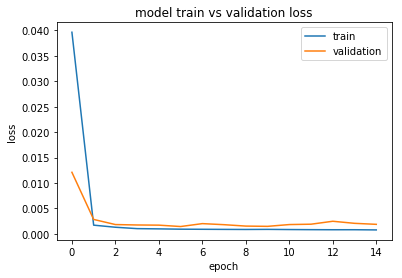

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

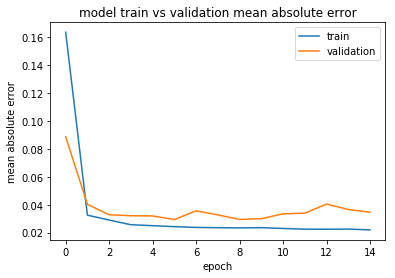

In [28]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
results = model.evaluate(x = test_input,
                        y = test_labels)
print('loss(test-set):', results)

466/466 [==============================] - 0s 142us/sample - loss: 0.0019 - mean_absolute_error: 0.0346
loss(test-set): [0.0018661618652421772, 0.034592703]


(466, 2, 1)
(466, 1)


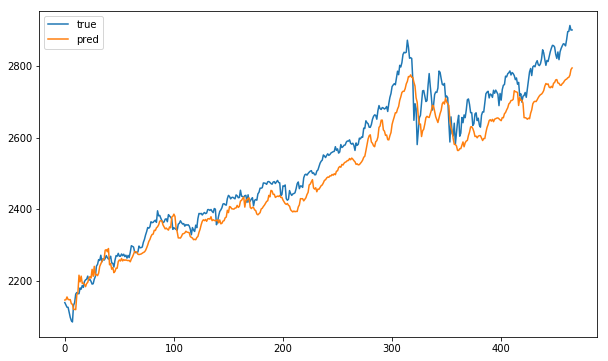

In [50]:
def plot_comparison():
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """

       # Use test-data.
    x = test_input
    y_true = y_scaler.inverse_transform(test_labels)
    
    #x = np.expand_dims(x, axis=1)
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    # Input-signals for the model.
    
    
    # Use the model to predict the output-signals.
    x_pred = model.predict(x)    
    
    #x_pred = x_pred.reshape(-1,1)
    print(x_pred.shape)
    x_pred = np.average(x_pred, axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(x_pred)  

    # For each output-signal.
    print(y_pred_rescaled.shape)

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    
plot_comparison()